In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
#Necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import skimage
import random
from tensorflow.keras.optimizers import Adam
import Denoise_layer # The custom built CVXPY layer
import matplotlib.pyplot as plt

In [3]:
#Getting the MNIST dataset
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape #Shapes of the variables

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
#number of samples taken
train_num = 10000
test_num = 2000

In [6]:
#slicing the data
x_train = x_train[:train_num]
y_train = y_train[:train_num]
x_test = x_test[:test_num]
y_test = y_test[:test_num]

In [7]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28), (10000,), (2000, 28, 28), (2000,))

In [8]:
y_test.shape

(2000,)

In [9]:
#Finding total number of images in training and test set
print(len(x_train))
print(len(x_test))

10000
2000


In [10]:
#normalizing the entire data
x_train = x_train/255.0
x_test = x_test/255.0

In [11]:
#Reshaping and Normalizing training and test images
x_train = x_train.reshape(train_num, 28, 28, 1)

x_test = x_test.reshape(test_num, 28, 28, 1)


In [12]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((10000, 28, 28, 1), (10000,), (2000, 28, 28, 1), (2000,))

In [13]:
epochs = 10
batchSize = 32
opt = Adam(learning_rate=0.001)

In [14]:
#VGG model Building using Keras
def VGG16model():
  model = Sequential()

  model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)))
  model.add(Conv2D(64, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  return model

In [15]:
#The instance for the cvxpy layer
def CVXPYmodel(inp_shape, lam):
    
    denoise = Denoise_layer.Denoise(input_shape=inp_shape,lam_val=lam,trainable=False)
    model = Sequential()
    model.add(denoise)
    model.compile()
    
    return model 

In [16]:
from sklearn.metrics import classification_report,confusion_matrix

### Model-5
+ Noise level= 0.5

In [17]:
import skimage
import matplotlib.pyplot as plt

In [18]:
#Adding noise to the dataset with the level
import skimage
noise_lvl_2 = 0.5
noise_x_train_2 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_2)  for x in x_train])
noise_x_test_2 = np.array([skimage.util.random_noise(x, mode='gaussian', seed=42, clip=True, var = noise_lvl_2) for x in x_test])

In [19]:
model_5 = VGG16model()

In [20]:
history_5 = model_5.fit(noise_x_train_2, y_train, epochs = epochs, batch_size = batchSize)#training the model

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
313/313 [==============================] - 23s 44ms/step - loss: 1.4879 - accuracy: 0.6154
Epoch 2/10
313/313 [==============================] - 10s 31ms/step - loss: 0.3393 - accuracy: 0.9053
Epoch 3/10
313/313 [==============================] - 10s 31ms/step - loss: 0.2939 - accuracy: 0.9217
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.3437 - accuracy: 0.9117
Epoch 5/10
313/313 [==============================] - 10s 32ms/step - loss: 0.2740 - accuracy: 0.9382
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.3457 - accuracy: 0.9227
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1927 - accuracy: 0.9536
Epoch 8/10
313/313 [==============================] - 10s 32ms/step - loss: 0.2048 - accuracy: 0.9528
Epoch 9/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1708 - accuracy: 0.9622
Epoch 10/10
313/313 [==============================] - 10s 32ms/step - loss: 0.151

In [21]:
#Function for showing the accuracy and loss plots
def ShowPlots(hist):
  plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(hist.history["accuracy"],'-ro',label="Accuracy")
  #plt.plot(hist.history["val_accuracy"],'-bo',label="Validation Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.subplot(122)
  plt.plot(hist.history["loss"],'-ro',label="Loss")
  #plt.plot(hist.history["val_loss"],'-bo',label="Validation Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  return plt.show()

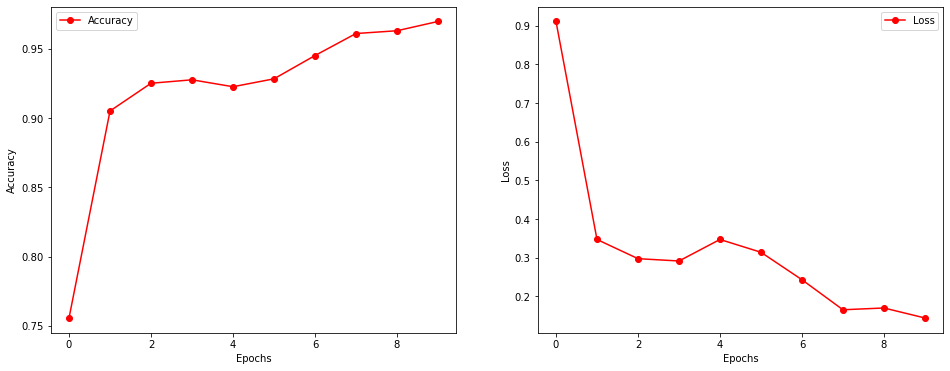

In [22]:
ShowPlots(history_5)

In [23]:
y_pred_5 = model_5.predict(noise_x_test_2)
y_pred_5 = np.argmax(y_pred_5,axis=1)

In [24]:
confusion_matrix(y_test,y_pred_5)

array([[171,   0,   2,   0,   0,   0,   2,   0,   0,   0],
       [  0, 226,   4,   3,   0,   1,   0,   0,   0,   0],
       [  0,   0, 213,   5,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0, 200,   0,   1,   0,   6,   0,   0],
       [  2,   0,   1,   1, 177,   0,   8,   0,   3,  25],
       [  0,   0,   0,   4,   0, 173,   0,   1,   1,   0],
       [  5,   0,   0,   0,   0,  13, 159,   0,   1,   0],
       [  0,   0,   9,  21,   0,   2,   0, 171,   0,   2],
       [  0,   0,   4,   3,   0,   0,   1,   0, 183,   1],
       [  0,   0,   2,   2,   1,   0,   0,   1,  12, 176]], dtype=int64)

In [25]:
print(classification_report(y_test,y_pred_5))#classification report

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       175
           1       1.00      0.97      0.98       234
           2       0.91      0.97      0.94       219
           3       0.84      0.97      0.90       207
           4       0.99      0.82      0.90       217
           5       0.91      0.97      0.94       179
           6       0.93      0.89      0.91       178
           7       0.96      0.83      0.89       205
           8       0.92      0.95      0.93       192
           9       0.86      0.91      0.88       194

    accuracy                           0.92      2000
   macro avg       0.93      0.93      0.92      2000
weighted avg       0.93      0.92      0.92      2000



### Model-6
+ noise level = 0.5
+ lamda value = 0.1

In [26]:
cvxpy_layer_1 = CVXPYmodel((28,28),0.1)#making the cvxpy model

In [27]:
denoised_train_1 = cvxpy_layer_1.predict(noise_x_train_2.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [28]:
denoised_train_1.shape

(10000, 28, 28, 1)

In [29]:
model_6 = VGG16model()

In [30]:
history_6 = model_6.fit(denoised_train_1,y_train,epochs= epochs,batch_size= batchSize)#training the model with the denoised data

Epoch 1/10
313/313 [==============================] - 10s 32ms/step - loss: 7.7124 - accuracy: 0.2277
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 1.4793 - accuracy: 0.4715
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 1.0611 - accuracy: 0.6297
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.8331 - accuracy: 0.7253
Epoch 5/10
313/313 [==============================] - 10s 32ms/step - loss: 0.7121 - accuracy: 0.7573
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.6968 - accuracy: 0.7755
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 0.5854 - accuracy: 0.8053
Epoch 8/10
313/313 [==============================] - 10s 32ms/step - loss: 0.5508 - accuracy: 0.8303
Epoch 9/10
313/313 [==============================] - 10s 32ms/step - loss: 0.5376 - accuracy: 0.8438
Epoch 10/10
313/313 [==============================] - 10s 32ms/step - loss: 0.396

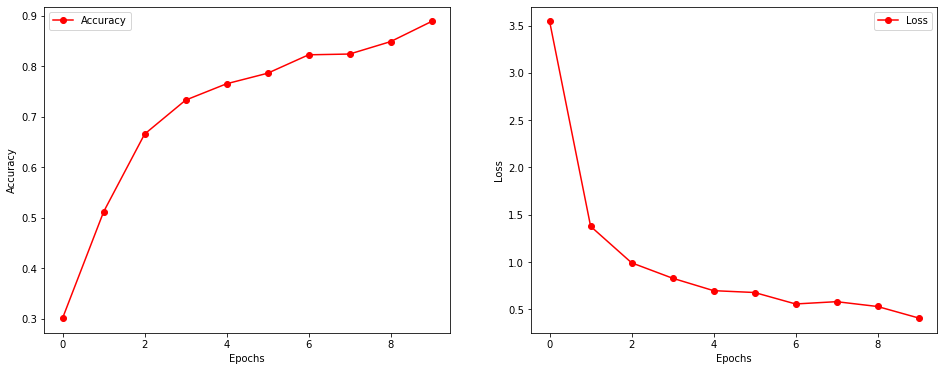

In [31]:
ShowPlots(history_6)

In [32]:
denoised_test_1 = cvxpy_layer_1.predict(noise_x_test_2.reshape(test_num,28,28))#Denoising the input images

In [33]:
denoised_test_1.shape

(2000, 28, 28, 1)

In [34]:
y_pred_6 = model_6.predict(denoised_test_1) #Predicting the denoised test data
y_pred_6 =np.argmax(y_pred_6,axis=1)

In [35]:
confusion_matrix(y_test,y_pred_6)

array([[172,   0,   2,   0,   0,   0,   1,   0,   0,   0],
       [  0, 220,   1,   8,   0,   0,   0,   0,   5,   0],
       [ 15,   0, 204,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  78, 110,   0,   0,   0,   1,  18,   0],
       [  1,   2,   0,   1,  80,  33,   8,   2,   4,  86],
       [ 12,   0,   1,   1,   0,  12,   0,   0, 151,   2],
       [ 34,   2,   0,   0,   0,   0, 138,   0,   4,   0],
       [  0,   0,  10,  11,   0,   0,   0, 180,   3,   1],
       [ 61,   0,  87,   1,   0,   1,   0,   1,  39,   2],
       [  1,   0,   0,   2,   0,   2,   0,  24,  18, 147]], dtype=int64)

In [36]:
print(classification_report(y_test,y_pred_6))

              precision    recall  f1-score   support

           0       0.58      0.98      0.73       175
           1       0.98      0.94      0.96       234
           2       0.53      0.93      0.68       219
           3       0.82      0.53      0.65       207
           4       1.00      0.37      0.54       217
           5       0.25      0.07      0.11       179
           6       0.94      0.78      0.85       178
           7       0.87      0.88      0.87       205
           8       0.16      0.20      0.18       192
           9       0.62      0.76      0.68       194

    accuracy                           0.65      2000
   macro avg       0.67      0.64      0.62      2000
weighted avg       0.69      0.65      0.63      2000



In [37]:
import math 
import numpy as np 
#function for calculating the PSNR value
def calculate_psnr(img1, img2): 
    # img1 and img2 have range [0, 255] 
    img1 = img1.astype(np.float64) 
    img2 = img2.astype(np.float64) 
    mse = np.mean((img1 - img2)**2) 
    if mse == 0:
        return float('inf') 
    return 20 * math.log10(1.0 / math.sqrt(mse))

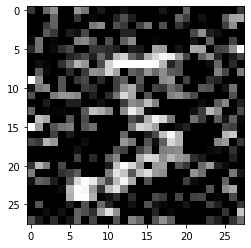

In [38]:
plt.imshow(denoised_train_1[0],cmap='gray')

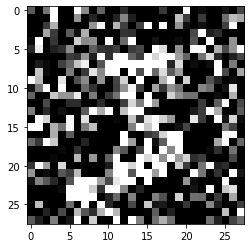

In [39]:
plt.imshow(noise_x_train_2[0],cmap='gray')

In [40]:
calculate_psnr(x_train[0],denoised_train_1[0])#1

10.959334639766835

In [41]:
calculate_psnr(x_train[0],noise_x_train_2[0]) #1

7.7724401292329794

In [42]:
psnr_denoised_1 = 0
for i,j in zip(x_train,denoised_train_1):
    psnr_denoised_1 = calculate_psnr(i,j) + psnr_denoised_1
psnr_denoised_1 = psnr_denoised_1/x_train.shape[0]
psnr_denoised_1

10.57404222508106

In [43]:
psnr_noised_1 = 0
for i,j in zip(x_train,noise_x_train_2):
    psnr_noised_1 = calculate_psnr(i,j) + psnr_noised_1
psnr_noised_1 = psnr_noised_1/x_train.shape[0]
psnr_noised_1

7.591076036370816

### Model-7
+ noise level = 0.5
+ lambda value = 0.3

In [44]:
cvxpy_layer_2 = CVXPYmodel((28,28),0.3) #instance for cvxpy model

In [45]:
denoised_train_2 = cvxpy_layer_2.predict(noise_x_train_2.reshape(train_num,28,28)) #Denoising the input images

C:\Users\phvpa\anaconda3\envs\CVXPY\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [46]:
model_7 = VGG16model()

In [47]:
history_7 = model_7.fit(denoised_train_2,y_train,epochs= epochs,batch_size= batchSize)#training with the denoised images

Epoch 1/10
313/313 [==============================] - 10s 32ms/step - loss: 8.4468 - accuracy: 0.1644
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 2.0111 - accuracy: 0.2430
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 1.8449 - accuracy: 0.3098
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 1.8365 - accuracy: 0.3263
Epoch 5/10
313/313 [==============================] - 10s 31ms/step - loss: 1.6366 - accuracy: 0.3715
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 1.3976 - accuracy: 0.4916
Epoch 7/10
313/313 [==============================] - 10s 32ms/step - loss: 1.3792 - accuracy: 0.5076
Epoch 8/10
313/313 [==============================] - 10s 32ms/step - loss: 1.0232 - accuracy: 0.6287
Epoch 9/10
313/313 [==============================] - 10s 32ms/step - loss: 0.7555 - accuracy: 0.7510
Epoch 10/10
313/313 [==============================] - 10s 32ms/step - loss: 0.705

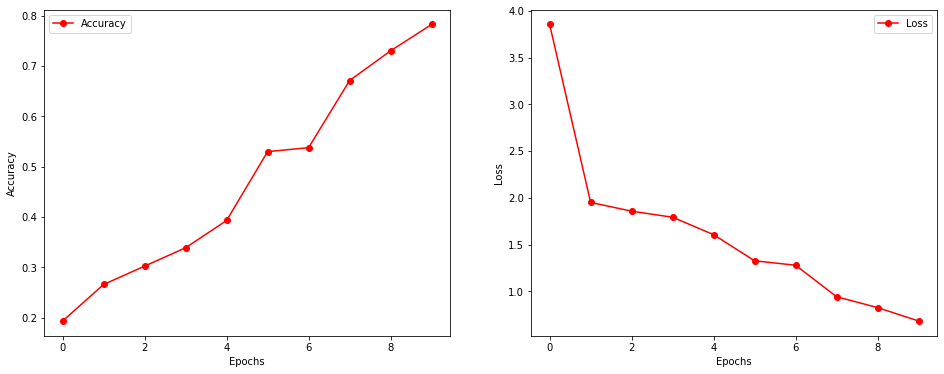

In [48]:
ShowPlots(history_7)

In [49]:
denoised_test_2 = cvxpy_layer_2.predict(noise_x_test_2.reshape(test_num,28,28)) #Denoising the input images-test

In [50]:
y_pred_7 = model_7.predict(denoised_test_2)#Predicting the denoised test data
y_pred_7 = np.argmax(y_pred_7,axis=1)

In [51]:
confusion_matrix(y_test,y_pred_7)#confusion matrix

array([[147,   0,   0,   0,   1,  22,   1,   0,   3,   1],
       [  0, 229,   3,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0, 186,  18,   0,   9,   3,   0,   3,   0],
       [  0,   0,  17, 180,   0,   4,   0,   1,   5,   0],
       [  0,   1,   0,   0, 186,   0,   6,   1,  15,   8],
       [  3,   0,  17,   6,   1, 131,   5,   1,  15,   0],
       [  3,   1,   0,   0,   1,   9, 164,   0,   0,   0],
       [  0,   1,   2,  45,   0,   0,   0, 141,   8,   8],
       [  0,   0,  37,  45,   2,  29,   2,   0,  74,   3],
       [  0,   0,   0,   7,   3,   3,   0,  10,  30, 141]], dtype=int64)

In [52]:
print(classification_report(y_test,y_pred_7))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       175
           1       0.99      0.98      0.98       234
           2       0.71      0.85      0.77       219
           3       0.60      0.87      0.71       207
           4       0.96      0.86      0.91       217
           5       0.63      0.73      0.68       179
           6       0.91      0.92      0.91       178
           7       0.92      0.69      0.79       205
           8       0.48      0.39      0.43       192
           9       0.88      0.73      0.79       194

    accuracy                           0.79      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.81      0.79      0.79      2000



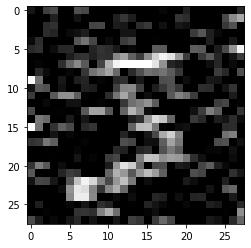

In [53]:
plt.imshow(denoised_train_2[0],cmap='gray')#denoised image

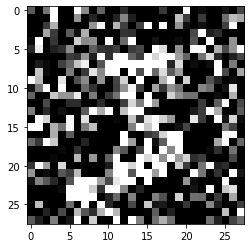

In [54]:
plt.imshow(noise_x_train_2[0],cmap='gray')#noise image

In [55]:
calculate_psnr(x_train[0],denoised_train_2[0])#1

12.132948746859348

In [56]:
calculate_psnr(x_train[0],noise_x_train_2[0])

7.7724401292329794

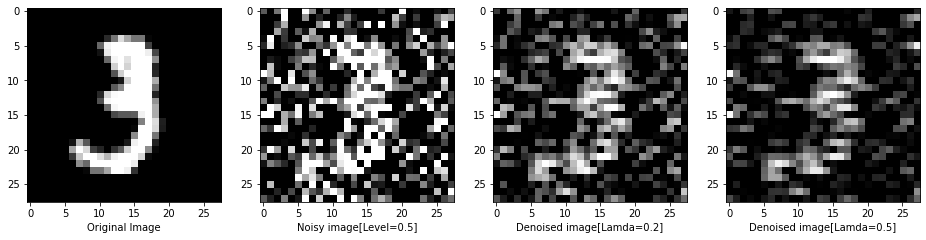

In [57]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 4, 1)
plt.imshow(x_train[10].reshape(28,28),cmap='gray')
plt.xlabel("Original Image")
plt.subplot(1, 4, 2)
plt.imshow(noise_x_train_2[10].reshape(28,28),cmap='gray')
plt.xlabel("Noisy image[Level=0.5]")
plt.subplot(1, 4, 3)
plt.imshow(denoised_train_1[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.2]")
plt.subplot(1, 4, 4)
plt.imshow(denoised_train_2[10].reshape(28,28),cmap='gray')
plt.xlabel("Denoised image[Lamda=0.5]")
plt.show()